In [1]:
import configparser
import sys
import binotools as bt
import numpy as np
import astropy.io.fits as fits
import time, datetime
import pylab as plt

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
def remove_end_from_string(s):
    return s[:s.rfind('end')]

def load_molecfit_par(par_file_name):
    """Load .par file and parse
    
    """
    
    with open(par_file_name) as f:
        file_content = remove_end_from_string('[section]\n' + f.read())

    config_parser = configparser.RawConfigParser(delimiters=':')
    config_parser.read_string(file_content)
    
    return config_parser

def save_molecfit_par(cp, output_par_name=sys.stdout):
    """Save molecfit parameter file
    
    """
    
    if type(output_par_name) is str:
        
        # Save to file
        with open(output_par_name, 'w') as par_file:
            cp.write(par_file, space_around_delimiters=True)

        # Delete first line
        with open(output_par_name, 'r') as par_file:
            head, tail = par_file.read().split('\n', 1)
        
        # Add end
        with open(output_par_name, 'w') as par_file:
            par_file.writelines(tail.replace(' :',':')+'end\n')
    
    else:
        cp.write(output_par_name)


In [3]:
cp = load_molecfit_par('molecfit_BLAS_2019A_star19.par')

In [88]:
cp.set('section','filename','/home/cmason/Documents/Research/Observing/Binospec/Bino_analysis/telluric_corrections/star19_spec1D_uncalib.txt')  # Data file name
cp.set('section','output_dir','/home/cmason/Documents/Research/Observing/Binospec/Bino_analysis/telluric_corrections/output')  # Directory for output files
cp.set('section','output_name','molecfit_star19_edit')  # Name for output files

# Observing dates
# cp.set('section','obsdate','96.0')  # Observing date in years or MJD in days
# cp.set('section','utc','96.0')  # UTC in s

# Observing conditions
# cp.set('section','telalt','96.0')  # Telescope altitude angle in deg
# cp.set('section','pres','96.0')  # Pressure in hPa
# cp.set('section','temp','96.0')  # Ambient temperature in deg C
# cp.set('section','m1temp','96.0')  # Mirror temperature in deg C

In [91]:
save_molecfit_par(cp, output_par_name='molecfit_BLAS_2019A_star19_edit.par')

In [4]:
config = configparser.SafeConfigParser(delimiters=':')
config_file = '../scripts/BLAS_1_2019.config'
config.read(config_file)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  """Entry point for launching an IPython kernel.


['../scripts/BLAS_1_2019.config']

In [5]:
datadir    = config.get('raw_data','data_dir')
spec2D_all = sorted(bt.insensitive_glob(datadir+'/*/*/reduced_series/obj_clean*abs_slits_lin.fits'))
nights     = np.array([s.split('individual_frames/')[-1].split('/')[0] for s in spec2D_all])

spec2D_all = spec2D_all
nights = np.unique(nights)

print('Found %i frames over %i nights' % (len(spec2D_all), len(nights)))

Found 63 frames over 13 nights


In [6]:
star_id = 19
wave_A = bt.get_wave_A_from_spec2D(spec2D_all[0])

plt.figure(figsize=(15,4), dpi=150)
for ss, spec2D_file in enumerate(spec2D_all):
    
    star_spec_filename = spec2D_file.replace('.fits', '_star%i.txt' % star_id)

    spec2D_hdu = fits.open(spec2D_file)
    
    hdr = spec2D_hdu[0].header
    
    UTC = time.strptime(hdr['UT'],'%H:%M:%S')
    UTC_sec = datetime.timedelta(hours=UTC.tm_hour,minutes=UTC.tm_min,seconds=UTC.tm_sec).total_seconds()
    
    cp.set('section','filename',star_spec_filename)  # Data file name
    cp.set('section','output_dir',config.get('calibration_data','telluric_dir')+'output_individualframes')  # Directory for output files
    cp.set('section','output_name',star_spec_filename.replace('.txt','').split('individual_frames/')[-1].replace('/','_'))  # Name for output files

    # Observing dates
    cp.set('section','obsdate',hdr['MJD'])  # Observing date in years or MJD in days
    cp.set('section','utc',UTC_sec)  # UTC in s

    # Observing conditions
    cp.set('section','telalt',hdr['EL'])  # Telescope altitude angle in deg
    cp.set('section','pres',hdr['ADCPRES'])  # Pressure in hPa
    cp.set('section','temp',hdr['ADCTEMP'])  # Ambient temperature in deg C
    cp.set('section','m1temp',hdr['ADCTEMP'])  # Mirror temperature in deg C
    
    # Save molecfit parameter file
    save_molecfit_par(cp, output_par_name=star_spec_filename.replace('.txt','_molecfit.par'))

    # Get stellar spectrum
    spec2D_star = spec2D_hdu[star_id+1].data
    spec1D_star_eachframe, FWHM_pix = bt.extract1D_psf(spec2D_star, psf_lim=0.02, plot_psf=False, ax=None)
    
    err1D = np.nanstd(spec2D_hdu[1].data, axis=0) * np.sqrt(2*FWHM_pix)

#     plt.plot(wave_A, spec1D_star_eachframe, c='tab:blue', lw=1)

    spec_tab = np.array([wave_A/10., spec1D_star_eachframe, err1D])
    np.savetxt(star_spec_filename, spec_tab.T, delimiter=' ')
    
# plt.ylim(0, 1000)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/Binotools-0.1.0-py3.7.egg/binotools/extract_spectra.py:36: RuntimeWarning: invalid value encountered in greater
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


KeyboardInterrupt: 

<Figure size 2250x600 with 0 Axes>

(0.75, 0.8)

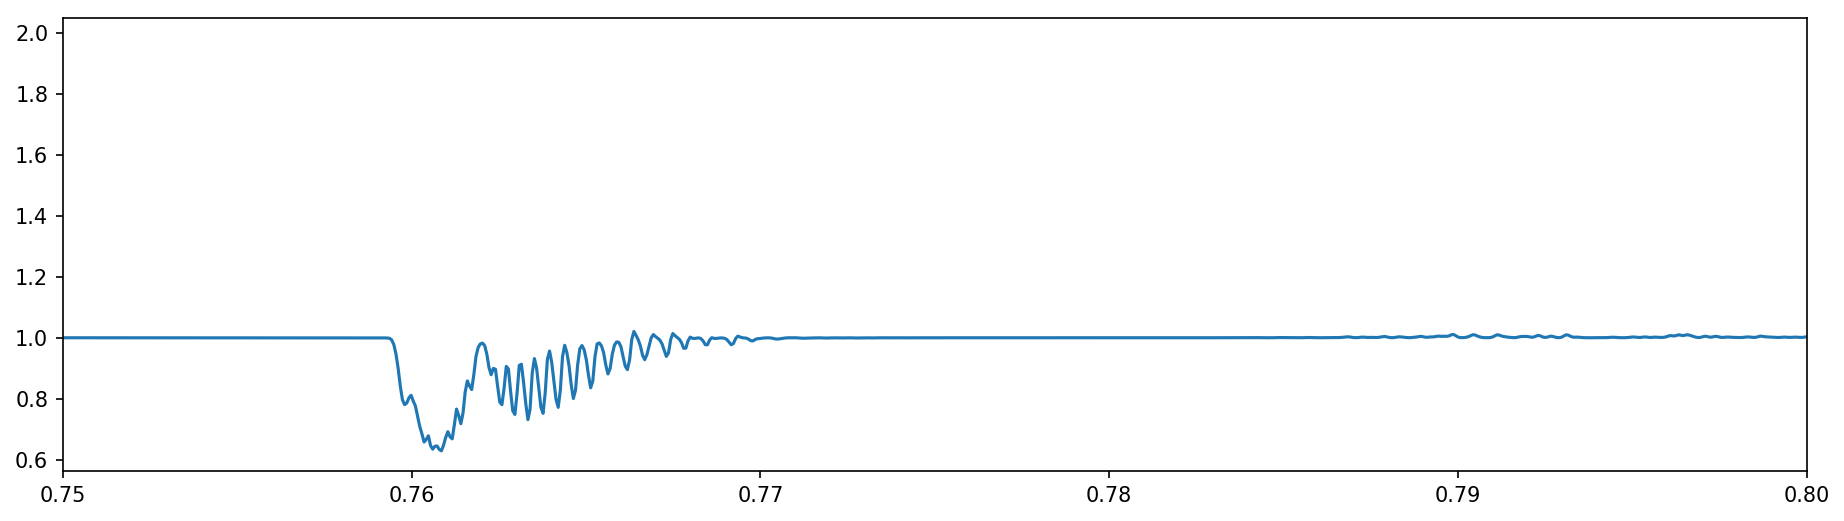

In [145]:
plt.figure(figsize=(15,4), dpi=150)

trans1 = np.genfromtxt('output_individualframes/2019.0208_BLAS_1a_600_8500_reduced_series_obj_clean000_abs_slits_lin_star19_tac.asc', skip_header=2)

wave = trans1[:,2]
trans = trans1[:,6]

# plt.plot(wave, trans)

trans2 = np.genfromtxt('output/molecfit_star19_tac.asc', skip_header=2)

wave = trans2[:,2]
trans_old = trans2[:,6]

plt.plot(wave, trans/trans_old)

plt.xlim(0.75, 0.8)

# Inspect all tellurics

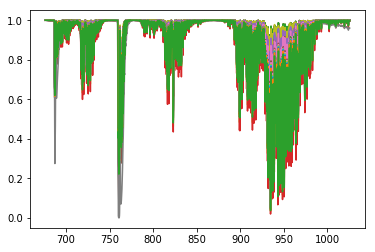

In [16]:
import os
star_id = int(config.get('slits','star_id'))
for ss, spec2D_file in enumerate(spec2D_all):

    spec2D_file_dir = spec2D_file.split(spec2D_file.split('/')[-1])[0]

    # Init telluric correction
    star_spec_filename    = spec2D_file.replace('.fits', '_star%i.txt' % star_id)
    transmission_filename = star_spec_filename.replace('.txt','_transmission.txt')
    if os.path.exists(transmission_filename) is False:
        transmission_filename = sorted(bt.insensitive_glob(spec2D_file_dir+'*_transmission.txt'))[-1]
    tellcorr = bt.TelluricCorrection(calib_dir='', transmission_filename=transmission_filename)
    plt.plot(tellcorr.wave_nm, tellcorr.transmission)